# A transformer-based model based on "What does self-attention learn from Masked Language Modelling?" paper

### Core parts of the transformer
- Separated position and spin
- Single attention layer


### Outline
1. Vanilla attention implementation
2. Factored attention implementation


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import tensorboardX

from utils import *
from train import *

In [45]:
X = torch.randn(100,1000,300)
idx = torch.randint(0,1000,(100,))
# create masked_X, Y=model(masked_X)
# X[:,idx,:]-Y[:,idx,:]

In [88]:
# load data
train_set = np.load('final_chains_T=1_num_iters=50_train_large.npy')
val_set = np.load('final_chains_T=1_num_iters=50_test_large.npy')

batch_size = 32
train_loader, test_loader = create_dataloaders(train_set, val_set, batch_size)

In [89]:
def generate_random_samples(vocab, num_samples=32, seq_length=200):
    """
    Generate random samples using the given vocabulary.
    
    Parameters:
    - vocab (dict): Vocabulary dictionary.
    - num_samples (int): Number of samples to generate.
    - seq_length (int): Length of each sequence.
    
    Returns:
    - samples (numpy.ndarray): Generated random samples of shape (num_samples, seq_length).
    """
    vocab_keys = list(vocab.keys())
    samples = np.random.choice(vocab_keys, size=(num_samples, seq_length))
    return samples

#vocab = {i: i for i in range(20)}
#random_samples = generate_random_samples(vocab, 32, 200)
#print(random_samples)

In [90]:
#batch_size = 32
#random_samples_train = generate_random_samples(vocab, 1000, 200)
#random_samples_test = generate_random_samples(vocab, 500, 200)
#train_loader, test_loader = create_dataloaders(random_samples_train, random_samples_test, batch_size)

In [91]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=vocab_size, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a  # parameter controlling how important positions are
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)

        batch_size, seq_length, num_features = s.shape

        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)

        x = self.word_embeddings(s) + self.a * position_embeddings
        
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)

        # Apply dropout and the final fully connected layer
        output = self.fc(self.dropout(attn_output))

        return output, scores



In [92]:
def evaluate(model, test_loader, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding_batch(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins_batch(input_seq, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
        positions = positions.squeeze(-1)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)
        predictions = [outputs[i][positions[i]] for i in range(positions.shape[0])]
        predictions = torch.stack(predictions)
        
        target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
        target_tokens = torch.stack(target_tokens)
        target_tokens = torch.where(target_tokens==1)[1]

        # Compute loss
        loss = criterion(predictions, target_tokens)
        epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(test_loader)

def train(model, train_loader, test_loader, vocab, optimizer, criterion, num_epochs=20, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            input_one_hot = one_hot_encoding_batch(data, vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins_batch(data, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
            target_tokens = torch.stack(target_tokens)
            target_tokens = torch.where(target_tokens==1)[1]
            predictions = [prediction[i][positions[i]] for i in range(positions.shape[0])]
            predictions = torch.stack(predictions)
            # Compute loss
            loss = criterion(predictions, target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [103]:
numbers = np.arange(-10, 11)
vocab = {numbers[i]: i for i in range(len(numbers))}
print(vocab)

{-10: 0, -9: 1, -8: 2, -7: 3, -6: 4, -5: 5, -4: 6, -3: 7, -2: 8, -1: 9, 0: 10, 1: 11, 2: 12, 3: 13, 4: 14, 5: 15, 6: 16, 7: 17, 8: 18, 9: 19, 10: 20}


In [106]:
# Define the parameters 
vocab_size = 21

numbers = np.arange(-10, 11)
vocab = {numbers[i]: i for i in range(len(numbers))}
L = 200
embedding_dim = 200
hidden_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [107]:
# Example usage:
model = VanillaAttentionTransformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=vocab_size, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, test_loader, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 2.5116


  5%|▌         | 1/20 [00:02<00:38,  2.02s/it]

Epoch 1 | Eval Loss: 3.4198


Epoch 2 | Train Loss: 2.4410


 10%|█         | 2/20 [00:04<00:36,  2.03s/it]

Epoch 2 | Eval Loss: 3.0288


Epoch 3 | Train Loss: 2.4727


 15%|█▌        | 3/20 [00:06<00:34,  2.01s/it]

Epoch 3 | Eval Loss: 3.2071


Epoch 4 | Train Loss: 2.4251


 20%|██        | 4/20 [00:07<00:31,  1.99s/it]

Epoch 4 | Eval Loss: 2.9968


Epoch 5 | Train Loss: 2.4053


 25%|██▌       | 5/20 [00:09<00:29,  1.98s/it]

Epoch 5 | Eval Loss: 3.1192


Epoch 6 | Train Loss: 2.4116


 30%|███       | 6/20 [00:11<00:27,  1.97s/it]

Epoch 6 | Eval Loss: 3.1978


Epoch 7 | Train Loss: 2.4163


 35%|███▌      | 7/20 [00:13<00:25,  1.97s/it]

Epoch 7 | Eval Loss: 3.1688


Epoch 8 | Train Loss: 2.4234


 40%|████      | 8/20 [00:15<00:23,  1.99s/it]

Epoch 8 | Eval Loss: 3.3513


Epoch 9 | Train Loss: 2.4321


 45%|████▌     | 9/20 [00:17<00:22,  2.00s/it]

Epoch 9 | Eval Loss: 3.2550


Epoch 10 | Train Loss: 2.4280


 50%|█████     | 10/20 [00:19<00:20,  2.02s/it]

Epoch 10 | Eval Loss: 3.4078


Epoch 11 | Train Loss: 2.3869


 55%|█████▌    | 11/20 [00:22<00:18,  2.03s/it]

Epoch 11 | Eval Loss: 4.0468


Epoch 12 | Train Loss: 2.4090


 60%|██████    | 12/20 [00:24<00:16,  2.01s/it]

Epoch 12 | Eval Loss: 3.7454


Epoch 13 | Train Loss: 2.4178


 65%|██████▌   | 13/20 [00:26<00:14,  2.01s/it]

Epoch 13 | Eval Loss: 3.4000


Epoch 14 | Train Loss: 2.3993


 70%|███████   | 14/20 [00:27<00:12,  2.00s/it]

Epoch 14 | Eval Loss: 3.4260


Epoch 15 | Train Loss: 2.4101


 75%|███████▌  | 15/20 [00:29<00:09,  1.99s/it]

Epoch 15 | Eval Loss: 3.7925


Epoch 16 | Train Loss: 2.3779


 80%|████████  | 16/20 [00:32<00:08,  2.01s/it]

Epoch 16 | Eval Loss: 3.6577


Epoch 17 | Train Loss: 2.4060


 85%|████████▌ | 17/20 [00:34<00:06,  2.00s/it]

Epoch 17 | Eval Loss: 3.0652


Epoch 18 | Train Loss: 2.3821


 90%|█████████ | 18/20 [00:35<00:03,  1.99s/it]

Epoch 18 | Eval Loss: 3.6495


Epoch 19 | Train Loss: 2.4246


 95%|█████████▌| 19/20 [00:37<00:01,  1.99s/it]

Epoch 19 | Eval Loss: 3.1063


Epoch 20 | Train Loss: 2.3975


100%|██████████| 13/13 [00:00<00:00, 14.93it/s]
                                               

Epoch 20 | Eval Loss: 3.4427


In [108]:
# To save only the decoder layer weights
attn_weights = torch.vstack(attn_weights)
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(random_samples_test.shape)

torch.Size([400, 200, 200])
(500, 200)


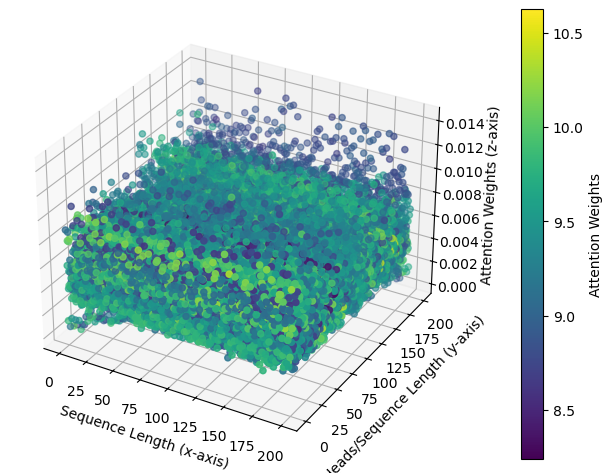

In [109]:
# loading self-attention weights)
caw = decoder_weights.mean(0).cpu().detach().numpy()

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Transpose the meshgrid to match the shape of attention_weights
x = x.T
y = y.T

# Flatten the x, y, and z (attention_weights) for plotting
x = x.flatten()
y = y.flatten()
z = caw.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap
# third distribution is more aligned one
sc = ax.scatter(x, y, z, c=np.dot(caw,random_samples_test[:200,:]), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Attention Weights')

# Labels
ax.set_xlabel('Sequence Length (x-axis)')
ax.set_ylabel('Heads/Sequence Length (y-axis)')
ax.set_zlabel('Attention Weights (z-axis)')


plt.tight_layout()
plt.show()


### Determine the J from the decoder weights
Ideas:
- To achieve that we set the negative weights equal to 0 and positive to 1

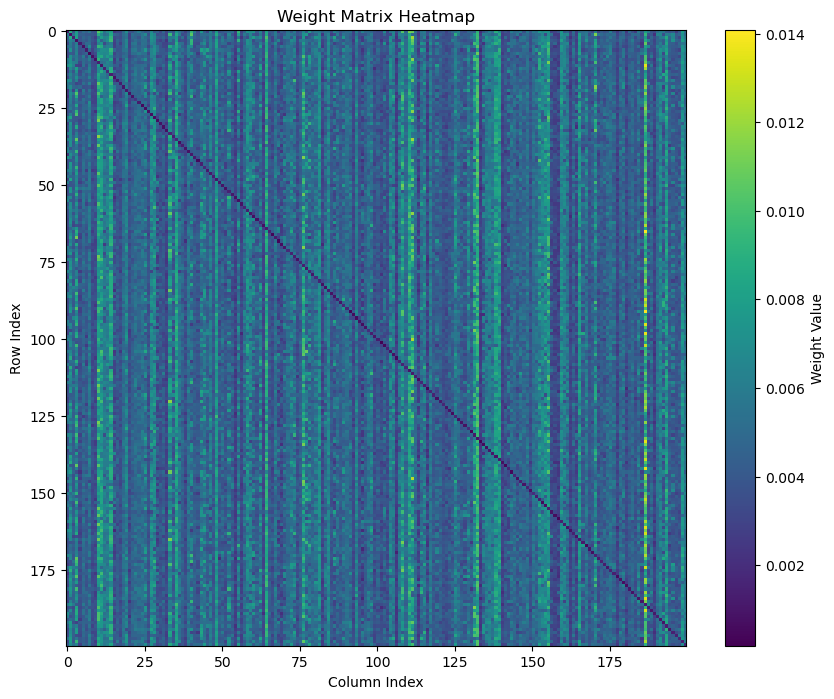

In [110]:
def generate_heatmap(weight_matrix):
    """
    Generates a heatmap from a given weight matrix.
    
    Parameters:
    weight_matrix (numpy.ndarray): A 2D numpy array of shape (200, 200) representing the weights.
    
    Returns:
    None
    """
    if weight_matrix.shape != (200, 200):
        raise ValueError("The weight matrix must be of shape (200, 200)")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(weight_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weight Matrix Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Example usage
#caw = decoder_weights.cpu().detach().numpy()
generate_heatmap(caw)

One interesting thing that the authors of the paper do not consider is the fact that they don't use pure Transformer but transformer with linear layers. Transformer without them struggles to learn meaningful contact maps.

## With feed-forward network
The way it is implemented in the masked nlp paper

In [111]:
'''
# Sequences for decoder
dec_chains_train = np.load('final_chains_T=1_num_iters=100_J_simple_test.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('final_chains_T=1_num_iters=100_J_simple_test.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)

batch_size = 32
train_loader, test_loader = create_dataloaders(dec_chains_train, dec_chains_test, batch_size)
'''

'\n# Sequences for decoder\ndec_chains_train = np.load(\'final_chains_T=1_num_iters=100_J_simple_test.npy\')\nprint("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)\n\ndec_chains_test = np.load(\'final_chains_T=1_num_iters=100_J_simple_test.npy\')\nprint("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)\n\nbatch_size = 32\ntrain_loader, test_loader = create_dataloaders(dec_chains_train, dec_chains_test, batch_size)\n'

In [112]:
batch_size = 32
random_samples_train = generate_random_samples(vocab, 1000, 200)
random_samples_test = generate_random_samples(vocab, 500, 200)
train_loader, test_loader = create_dataloaders(random_samples_train, random_samples_test, batch_size)

In [113]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=vocab_size, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)
        output = self.fc(self.dropout(attn_output))
        return output, scores

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_hidden):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [114]:
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, a, max_seq_length, num_spins=vocab_size, dropout_rate=0.0):
        super(SimpleTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a
        self.feed_forward = PositionWiseFeedForward(embed_dim, hidden_dim)
        self.attention = VanillaAttentionTransformer(embed_dim, a, max_seq_length, num_spins, dropout_rate)
    
    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)
        batch_size, seq_length, num_features = s.shape
        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)
        x = self.word_embeddings(s) + self.a * position_embeddings
        x, attn_weights = self.attention(x)
        output = self.feed_forward(x)
        return output, attn_weights


In [115]:
def evaluate(model, test_loader, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding_batch(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins_batch(input_seq, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
        positions = positions.squeeze(-1)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)
        predictions = [outputs[i][positions[i]] for i in range(positions.shape[0])]
        predictions = torch.stack(predictions)
        
        target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
        target_tokens = torch.stack(target_tokens)
        target_tokens = torch.where(target_tokens==1)[1]

        # Compute loss
        loss = criterion(predictions, target_tokens)
        epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(test_loader)

def train(model, train_loader, test_loader, vocab, optimizer, criterion, num_epochs=50, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            input_one_hot = one_hot_encoding_batch(data, vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins_batch(data, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
            target_tokens = torch.stack(target_tokens)
            target_tokens = torch.where(target_tokens==1)[1]
            predictions = [prediction[i][positions[i]] for i in range(positions.shape[0])]
            predictions = torch.stack(predictions)
            # Compute loss
            loss = criterion(predictions, target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [116]:
# Define the parameters 
vocab_size = 21

# set vocabulary
numbers = np.arange(-10, 11)
vocab = {numbers[i]: i for i in range(len(numbers))}

L = 200
embedding_dim = 200
hidden_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [117]:
# Example usage:
model = SimpleTransformer(embed_dim=embedding_dim, hidden_dim=hidden_dim, a=1, max_seq_length=L, num_spins=vocab_size, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, test_loader, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 16.2265


  2%|▏         | 1/50 [00:04<03:49,  4.68s/it]

Epoch 1 | Eval Loss: 5.4499


Epoch 2 | Train Loss: 14.6684


  4%|▍         | 2/50 [00:09<03:39,  4.57s/it]

Epoch 2 | Eval Loss: 3.2793


Epoch 3 | Train Loss: 13.6854


  6%|▌         | 3/50 [00:13<03:33,  4.53s/it]

Epoch 3 | Eval Loss: 3.1830


Epoch 4 | Train Loss: 12.3380


  8%|▊         | 4/50 [00:18<03:28,  4.52s/it]

Epoch 4 | Eval Loss: 3.0628


Epoch 5 | Train Loss: 12.2386


 10%|█         | 5/50 [00:22<03:22,  4.51s/it]

Epoch 5 | Eval Loss: 3.0486


Epoch 6 | Train Loss: 12.2495


 12%|█▏        | 6/50 [00:27<03:18,  4.51s/it]

Epoch 6 | Eval Loss: 3.0629


Epoch 7 | Train Loss: 12.2541


 14%|█▍        | 7/50 [00:31<03:14,  4.52s/it]

Epoch 7 | Eval Loss: 3.0459


Epoch 8 | Train Loss: 12.2384


 16%|█▌        | 8/50 [00:36<03:10,  4.54s/it]

Epoch 8 | Eval Loss: 3.0589


Epoch 9 | Train Loss: 12.2515


 18%|█▊        | 9/50 [00:40<03:03,  4.48s/it]

Epoch 9 | Eval Loss: 3.0582


Epoch 10 | Train Loss: 12.2536


 20%|██        | 10/50 [00:44<02:57,  4.45s/it]

Epoch 10 | Eval Loss: 3.0478


Epoch 11 | Train Loss: 12.2204


 22%|██▏       | 11/50 [00:49<02:52,  4.43s/it]

Epoch 11 | Eval Loss: 3.0620


Epoch 12 | Train Loss: 12.2604


 24%|██▍       | 12/50 [00:53<02:47,  4.41s/it]

Epoch 12 | Eval Loss: 3.0478


Epoch 13 | Train Loss: 12.2307


 26%|██▌       | 13/50 [00:58<02:43,  4.43s/it]

Epoch 13 | Eval Loss: 3.0498


Epoch 14 | Train Loss: 12.2402


 28%|██▊       | 14/50 [01:02<02:41,  4.50s/it]

Epoch 14 | Eval Loss: 3.0429


Epoch 15 | Train Loss: 12.2026


 30%|███       | 15/50 [01:07<02:38,  4.52s/it]

Epoch 15 | Eval Loss: 3.0620


Epoch 16 | Train Loss: 12.2276


 32%|███▏      | 16/50 [01:12<02:35,  4.56s/it]

Epoch 16 | Eval Loss: 3.0531


Epoch 17 | Train Loss: 12.2381


 34%|███▍      | 17/50 [01:16<02:32,  4.61s/it]

Epoch 17 | Eval Loss: 3.0507


Epoch 18 | Train Loss: 12.2096


 36%|███▌      | 18/50 [01:21<02:27,  4.60s/it]

Epoch 18 | Eval Loss: 3.0752


Epoch 19 | Train Loss: 12.2265


 38%|███▊      | 19/50 [01:26<02:22,  4.61s/it]

Epoch 19 | Eval Loss: 3.0480


Epoch 20 | Train Loss: 12.2227


 40%|████      | 20/50 [01:31<02:23,  4.77s/it]

Epoch 20 | Eval Loss: 3.0650


Epoch 21 | Train Loss: 12.2423


 42%|████▏     | 21/50 [01:36<02:19,  4.83s/it]

Epoch 21 | Eval Loss: 3.0587


Epoch 22 | Train Loss: 12.2073


 44%|████▍     | 22/50 [01:40<02:14,  4.79s/it]

Epoch 22 | Eval Loss: 3.0690


Epoch 23 | Train Loss: 12.2251


 46%|████▌     | 23/50 [01:45<02:07,  4.73s/it]

Epoch 23 | Eval Loss: 3.0661


Epoch 24 | Train Loss: 12.2451


 48%|████▊     | 24/50 [01:50<02:02,  4.70s/it]

Epoch 24 | Eval Loss: 3.0676


Epoch 25 | Train Loss: 12.2314


 50%|█████     | 25/50 [01:54<01:56,  4.66s/it]

Epoch 25 | Eval Loss: 3.0546


Epoch 26 | Train Loss: 12.2348


 52%|█████▏    | 26/50 [01:59<01:51,  4.63s/it]

Epoch 26 | Eval Loss: 3.0633


Epoch 27 | Train Loss: 12.2114


 54%|█████▍    | 27/50 [02:03<01:46,  4.63s/it]

Epoch 27 | Eval Loss: 3.0630


Epoch 28 | Train Loss: 12.2483


 56%|█████▌    | 28/50 [02:08<01:41,  4.63s/it]

Epoch 28 | Eval Loss: 3.0534


Epoch 29 | Train Loss: 12.2075


 58%|█████▊    | 29/50 [02:13<01:37,  4.65s/it]

Epoch 29 | Eval Loss: 3.0503


Epoch 30 | Train Loss: 12.2124


 60%|██████    | 30/50 [02:17<01:33,  4.65s/it]

Epoch 30 | Eval Loss: 3.0637


Epoch 31 | Train Loss: 12.2291


 62%|██████▏   | 31/50 [02:22<01:28,  4.63s/it]

Epoch 31 | Eval Loss: 3.0427


Epoch 32 | Train Loss: 12.2069


 64%|██████▍   | 32/50 [02:27<01:23,  4.67s/it]

Epoch 32 | Eval Loss: 3.0682


Epoch 33 | Train Loss: 12.2194


 66%|██████▌   | 33/50 [02:31<01:19,  4.68s/it]

Epoch 33 | Eval Loss: 3.0570


Epoch 34 | Train Loss: 12.1911


 68%|██████▊   | 34/50 [02:36<01:14,  4.67s/it]

Epoch 34 | Eval Loss: 3.0552


Epoch 35 | Train Loss: 12.1849


 70%|███████   | 35/50 [02:41<01:09,  4.66s/it]

Epoch 35 | Eval Loss: 3.0556


Epoch 36 | Train Loss: 12.2352


 72%|███████▏  | 36/50 [02:45<01:05,  4.66s/it]

Epoch 36 | Eval Loss: 3.0530


Epoch 37 | Train Loss: 12.2165


 74%|███████▍  | 37/50 [02:50<01:00,  4.65s/it]

Epoch 37 | Eval Loss: 3.0571


Epoch 38 | Train Loss: 12.2104


 76%|███████▌  | 38/50 [02:54<00:55,  4.61s/it]

Epoch 38 | Eval Loss: 3.0557


Epoch 39 | Train Loss: 12.2315


 78%|███████▊  | 39/50 [02:59<00:50,  4.59s/it]

Epoch 39 | Eval Loss: 3.0618


Epoch 40 | Train Loss: 12.2151


 80%|████████  | 40/50 [03:04<00:46,  4.61s/it]

Epoch 40 | Eval Loss: 3.0557


Epoch 41 | Train Loss: 12.2256


 82%|████████▏ | 41/50 [03:08<00:41,  4.60s/it]

Epoch 41 | Eval Loss: 3.0444


Epoch 42 | Train Loss: 12.2194


 84%|████████▍ | 42/50 [03:13<00:36,  4.59s/it]

Epoch 42 | Eval Loss: 3.0461


Epoch 43 | Train Loss: 12.2163


 86%|████████▌ | 43/50 [03:17<00:32,  4.57s/it]

Epoch 43 | Eval Loss: 3.0481


Epoch 44 | Train Loss: 12.2052


 88%|████████▊ | 44/50 [03:22<00:27,  4.57s/it]

Epoch 44 | Eval Loss: 3.0585


Epoch 45 | Train Loss: 12.2266


 90%|█████████ | 45/50 [03:27<00:23,  4.60s/it]

Epoch 45 | Eval Loss: 3.0570


Epoch 46 | Train Loss: 12.2239


 92%|█████████▏| 46/50 [03:31<00:18,  4.59s/it]

Epoch 46 | Eval Loss: 3.0525


Epoch 47 | Train Loss: 12.2054


 94%|█████████▍| 47/50 [03:36<00:13,  4.57s/it]

Epoch 47 | Eval Loss: 3.0501


Epoch 48 | Train Loss: 12.2143


 96%|█████████▌| 48/50 [03:40<00:09,  4.61s/it]

Epoch 48 | Eval Loss: 3.0530


Epoch 49 | Train Loss: 12.2141


 98%|█████████▊| 49/50 [03:45<00:04,  4.61s/it]

Epoch 49 | Eval Loss: 3.0475


Epoch 50 | Train Loss: 12.2279


100%|██████████| 16/16 [00:01<00:00, 13.90it/s]
                                               

Epoch 50 | Eval Loss: 3.0551


In [120]:
attn_weights = torch.vstack(attn_weights)
# To save only the decoder layer weights
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(random_samples_test.shape)

torch.Size([1000, 200, 200])
(500, 200)


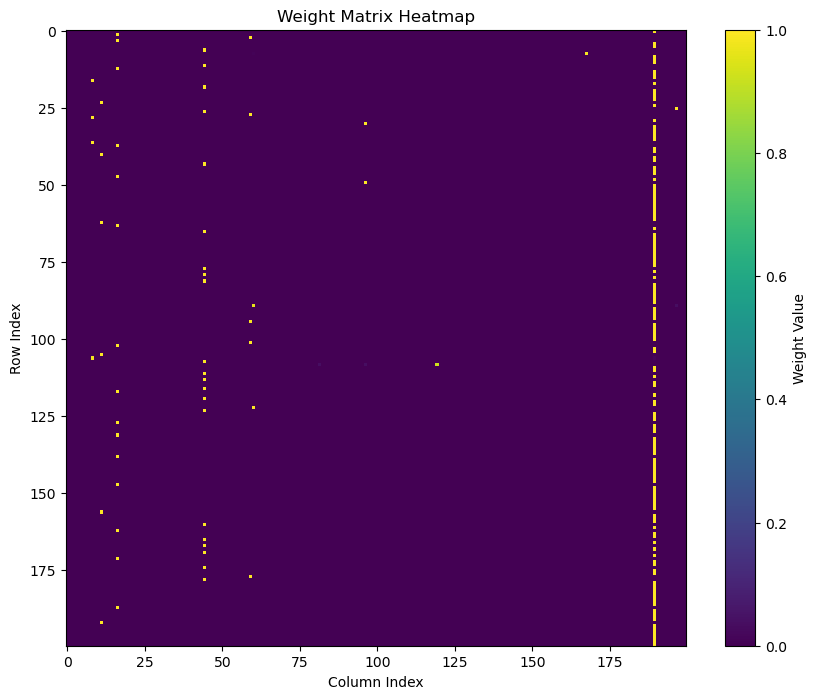

In [122]:
caw = decoder_weights[-1].cpu().detach().numpy()
generate_heatmap(caw)

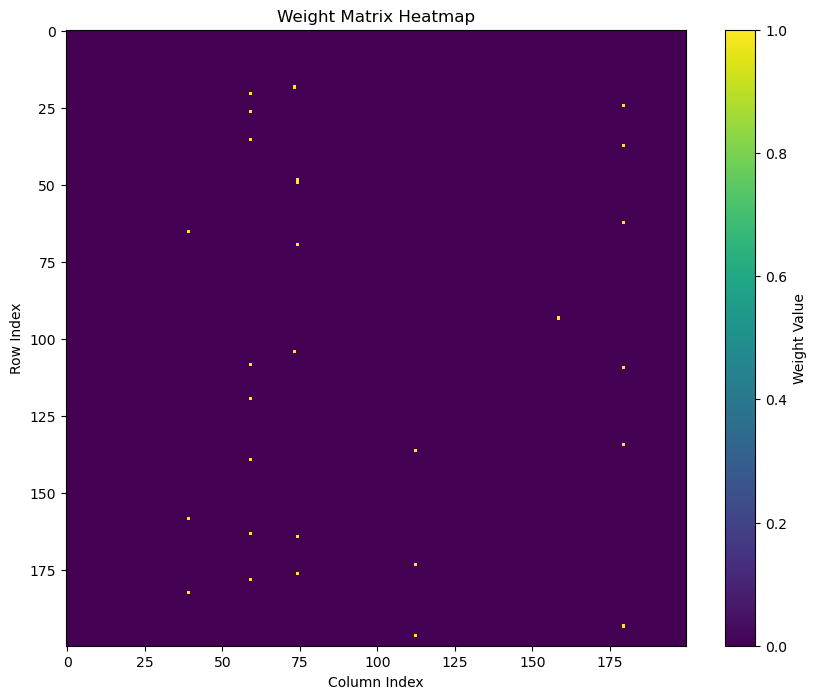

28.0

In [75]:
caw[caw<0.05] = 0
caw[caw>0.05] = 1
generate_heatmap(caw)
np.sum(caw)

To fully reproduce results we should consider vocabulary of 20 (equal to number of amino acids)

## Previous implementations

In [198]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        s = torch.tensor(s, dtype=torch.float)
        masked_token = torch.tensor(masked_token, dtype=torch.float)
        #print("the sequence with the masked token:", s)
        print("shape of position ids before embedding:", position_ids.shape)
        print("shape the sequence with the masked token:", s.shape)
        print("value of the word embedding:", self.word_embeddings(s).shape)
        print("positional embedding:", self.position_embeddings(position_ids))
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)) # (batch_size,embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.dropout(self.fc(attn_output))
        return output
    
class FactoredAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(FactoredAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins, embed_dim)
        self.word_embedding.weight.requires_grad = False
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        # masked token should be equal to 0
        # masked_token = torch.tensor([0])
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s)) # (embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.fc(self.dropout(attn_output))
        return output